# 序列到序列学习在机器翻译中的应用
:label:`sec_seq2seq`

在所谓的序列到序列问题中，例如机器翻译
（如:numref:`sec_machine_translation`所述），
输入和输出都是长度可变且未对齐的序列，
我们通常依赖编码器-解码器架构
（:numref:`sec_encoder-decoder`）。
在本节中，
我们将展示一种编码器-解码器架构的应用，
其中编码器和解码器都实现为RNN，
用于机器翻译任务
:cite:`Sutskever.Vinyals.Le.2014,Cho.Van-Merrienboer.Gulcehre.ea.2014`。

这里，编码器RNN将接受一个长度可变的序列作为输入，
并将其转换为固定形状的隐藏状态。
稍后，在:numref:`chap_attention-and-transformers`中，
我们将介绍注意力机制，
这使得我们可以访问编码后的输入，
而不需要将整个输入压缩成单个固定长度的表示。

然后为了生成输出序列，
一次生成一个标记，
由单独的RNN组成的解码器模型
将根据输入序列
以及输出中前面的标记来预测每个后续的目标标记。
在训练过程中，解码器通常会基于
官方“真实标签”中的前序标记进行条件化。
然而，在测试时，我们希望使解码器的每个输出
基于已经预测出的标记进行条件化。
注意，如果忽略编码器，
序列到序列架构中的解码器的行为就像一个普通的语言模型。
:numref:`fig_seq2seq`说明了
如何使用两个RNN
进行机器翻译中的序列到序列学习。


![使用RNN编码器和RNN解码器进行序列到序列学习。](../img/seq2seq.svg)
:label:`fig_seq2seq`

在:numref:`fig_seq2seq`中，
特殊的"&lt;eos&gt;"标记
表示序列的结束。
一旦生成此标记，我们的模型就可以停止做出预测。
在RNN解码器的初始时间步长，
有两个特别的设计决策需要注意：
首先，我们在每个输入的开始处使用一个特殊的
序列开始"&lt;bos&gt;"标记。
其次，我们可以将
编码器的最终隐藏状态
在每个解码时间步骤中馈送到解码器
:cite:`Cho.Van-Merrienboer.Gulcehre.ea.2014`。
在其他一些设计中，
例如:citet:`Sutskever.Vinyals.Le.2014`，
RNN编码器的最终隐藏状态
仅用于初始化解码器的第一个解码步骤的隐藏状态。

In [1]:
import collections
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

## Teacher Forcing

在输入序列上运行编码器相对直接，
处理解码器的输入和输出则需要更加小心。
最常见的方法有时被称为*teacher forcing*。
这里，原始的目标序列（标记标签）
被作为输入提供给解码器。
更具体地说，
特殊的序列开始标记
和原始目标序列，
不包括最后一个标记，
被连接起来作为解码器的输入，
而解码器的输出（训练用的标签）是
原始目标序列，
向后移一个标记：
"&lt;bos&gt;", "Ils", "regardent", "." $\rightarrow$
"Ils", "regardent", ".", "&lt;eos&gt;" (:numref:`fig_seq2seq`)。

我们在
:numref:`subsec_loading-seq-fixed-len`
中为teacher forcing准备了训练数据，
其中用于自监督学习的标记偏移
类似于
:numref:`sec_language-model`中的语言模型训练。
另一种方法是
将前一时间步*预测*的标记
作为当前解码器的输入。


下面，我们将更详细地解释
:numref:`fig_seq2seq`中描绘的设计。
我们将在英语-法语数据集上训练这个模型进行机器翻译，
如在
:numref:`sec_machine_translation`中介绍的那样。

## Encoder

回想一下，编码器将长度可变的输入序列
转换为固定形状的*上下文变量* $\mathbf{c}$ (见 :numref:`fig_seq2seq`)。


考虑单个序列示例（批量大小为1）。
假设输入序列为 $x_1, \ldots, x_T$，
使得 $x_t$ 是第 $t^{\textrm{th}}$ 个标记。
在时间步 $t$，RNN将
$x_t$ 的输入特征向量 $\mathbf{x}_t$
以及来自上一个时间步的隐藏状态 $\mathbf{h} _{t-1}$
转换成当前的隐藏状态 $\mathbf{h}_t$。
我们可以使用函数 $f$ 来表示
RNN的循环层的转换：

$$\mathbf{h}_t = f(\mathbf{x}_t, \mathbf{h}_{t-1})。$$

通常，编码器通过定制的函数 $q$ 将所有时间步的隐藏状态
转换成上下文变量：

$$\mathbf{c} =  q(\mathbf{h}_1, \ldots, \mathbf{h}_T)。$$

例如，在 :numref:`fig_seq2seq` 中，
上下文变量就是隐藏状态 $\mathbf{h}_T$，
对应于编码器RNN处理完输入序列的最后一个标记后的表示。

在这个例子中，我们使用了一个单向RNN
来设计编码器，
其中隐藏状态仅依赖于该时间步及其之前的时间步的输入子序列。
我们也可以使用双向RNN来构建编码器。
在这种情况下，隐藏状态依赖于时间步之前和之后的子序列
（包括当前时间步的输入），
从而编码整个序列的信息。


现在让我们[**实现RNN编码器**]。
注意我们使用了一个*嵌入层*
来获取输入序列中每个标记的特征向量。
嵌入层的权重是一个矩阵，
其行数对应于
输入词汇表的大小(`vocab_size`)
列数对应于
特征向量的维度(`embed_size`)。
对于任何输入标记索引 $i$，
嵌入层从权重矩阵中提取第 $i^{\textrm{th}}$ 行
（从0开始）以返回其特征向量。
这里我们使用多层GRU实现编码器。

In [2]:
def init_seq2seq(module):  #@save
    """Initialize weights for sequence-to-sequence learning."""
    if type(module) == nn.Linear:
         nn.init.xavier_uniform_(module.weight)
    if type(module) == nn.GRU:
        for param in module._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(module._parameters[param])

In [3]:
class Seq2SeqEncoder(d2l.Encoder):  #@save
    """The RNN encoder for sequence-to-sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = d2l.GRU(embed_size, num_hiddens, num_layers, dropout)
        self.apply(init_seq2seq)

    def forward(self, X, *args):
        # X shape: (batch_size, num_steps)
        embs = self.embedding(X.t().type(torch.int64))
        # embs shape: (num_steps, batch_size, embed_size)
        outputs, state = self.rnn(embs)
        # outputs shape: (num_steps, batch_size, num_hiddens)
        # state shape: (num_layers, batch_size, num_hiddens)
        return outputs, state

让我们用一个具体的例子
来[**说明上述编码器的实现。**]
下面，我们实例化一个两层的GRU编码器
其隐藏单元的数量为16。
给定一批序列输入`X`
（批量大小$=4$；时间步数$=9$），
最后一层在所有时间步的隐藏状态
（由编码器的循环层返回的`enc_outputs`）
是一个形状为
（时间步数，批量大小，隐藏单元数量）
的张量。

In [4]:
vocab_size, embed_size, num_hiddens, num_layers = 10, 8, 16, 2
batch_size, num_steps = 4, 9
encoder = Seq2SeqEncoder(vocab_size, embed_size, num_hiddens, num_layers)
X = torch.zeros((batch_size, num_steps))
enc_outputs, enc_state = encoder(X)
d2l.check_shape(enc_outputs, (num_steps, batch_size, num_hiddens))

由于我们在这里使用的是GRU，
在最后一个时间步的多层隐藏状态的形状是
（隐藏层数，批量大小，隐藏单元数）。

In [5]:
d2l.check_shape(enc_state, (num_layers, batch_size, num_hiddens))

## [**解码器**]
:label:`sec_seq2seq_decoder`

给定目标输出序列 $y_1, y_2, \ldots, y_{T'}$，对于每个时间步 $t'$（我们使用 $t^\prime$ 来区分输入序列的时间步），解码器为每个可能在步骤 $y_{t'+1}$ 出现的标记分配一个预测概率，该概率基于目标序列中的前序标记 $y_1, \ldots, y_{t'}$ 和上下文变量 $\mathbf{c}$，即 $P(y_{t'+1} \mid y_1, \ldots, y_{t'}, \mathbf{c})$。

为了预测目标序列中后续的标记 $t^\prime+1$，RNN 解码器以前一步的目标标记 $y_{t^\prime}$、前一时间步的 RNN 隐藏状态 $\mathbf{s}_{t^\prime-1}$ 以及上下文变量 $\mathbf{c}$ 作为输入，并将它们转换为当前时间步的隐藏状态 $\mathbf{s}_{t^\prime}$。我们可以用函数 $g$ 表示解码器隐藏层的变换：

$$\mathbf{s}_{t^\prime} = g(y_{t^\prime-1}, \mathbf{c}, \mathbf{s}_{t^\prime-1}).$$
:eqlabel:`eq_seq2seq_s_t`

获得解码器的隐藏状态后，我们可以使用输出层和 softmax 操作来计算后续输出标记 ${t^\prime+1}$ 的预测分布 $p(y_{t^{\prime}+1} \mid y_1, \ldots, y_{t^\prime}, \mathbf{c})$。

按照 :numref:`fig_seq2seq`，在实现解码器时，我们直接使用编码器最后一个时间步的隐藏状态来初始化解码器的隐藏状态。这要求 RNN 编码器和 RNN 解码器具有相同数量的层和隐藏单元。为了进一步结合编码后的输入序列信息，在所有时间步上将上下文变量与解码器输入连接起来。为了预测输出标记的概率分布，我们使用全连接层将 RNN 解码器最后一层的隐藏状态进行变换。

In [6]:
class Seq2SeqDecoder(d2l.Decoder):
    """The RNN decoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = d2l.GRU(embed_size+num_hiddens, num_hiddens,
                           num_layers, dropout)
        self.dense = nn.LazyLinear(vocab_size)
        self.apply(init_seq2seq)

    def init_state(self, enc_all_outputs, *args):
        return enc_all_outputs

    def forward(self, X, state):
        # X shape: (batch_size, num_steps)
        # embs shape: (num_steps, batch_size, embed_size)
        embs = self.embedding(X.t().type(torch.int32))
        enc_output, hidden_state = state
        # context shape: (batch_size, num_hiddens)
        context = enc_output[-1]
        # Broadcast context to (num_steps, batch_size, num_hiddens)
        context = context.repeat(embs.shape[0], 1, 1)
        # Concat at the feature dimension
        embs_and_context = torch.cat((embs, context), -1)
        outputs, hidden_state = self.rnn(embs_and_context, hidden_state)
        outputs = self.dense(outputs).swapaxes(0, 1)
        # outputs shape: (batch_size, num_steps, vocab_size)
        # hidden_state shape: (num_layers, batch_size, num_hiddens)
        return outputs, [enc_output, hidden_state]

为了[**说明实现的解码器**]，我们在下面使用与前述编码器相同的超参数来实例化它。正如我们所见，解码器的输出形状变为（批量大小，时间步数，词汇量大小），其中张量的最后一个维度存储了预测的令牌分布。

In [7]:
decoder = Seq2SeqDecoder(vocab_size, embed_size, num_hiddens, num_layers)
state = decoder.init_state(encoder(X))
dec_outputs, state = decoder(X, state)
d2l.check_shape(dec_outputs, (batch_size, num_steps, vocab_size))
d2l.check_shape(state[1], (num_layers, batch_size, num_hiddens))

上述RNN编码器-解码器模型中的层在:numref:`fig_seq2seq_details`中进行了总结。

![Layers in an RNN encoder--decoder model.](../img/seq2seq-details.svg)
:label:`fig_seq2seq_details`



## 用于序列到序列学习的编码器-解码器


将所有内容整合到代码中，得到如下结果：

In [8]:
class Seq2Seq(d2l.EncoderDecoder):  #@save
    """The RNN encoder--decoder for sequence to sequence learning."""
    def __init__(self, encoder, decoder, tgt_pad, lr):
        super().__init__(encoder, decoder)
        self.save_hyperparameters()

    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)

    def configure_optimizers(self):
        # Adam optimizer is used here
        return torch.optim.Adam(self.parameters(), lr=self.lr)

## 损失函数与掩码

在每个时间步，解码器预测输出标记的概率分布。
与语言模型一样，
我们可以应用softmax
来获得分布
并计算交叉熵损失以进行优化。
回想一下 :numref:`sec_machine_translation`
特殊填充标记被添加到序列的末尾
因此长度不同的序列
可以高效地以相同形状的小批量加载。
然而，填充标记的预测
应该从损失计算中排除。
为此，我们可以
[**用零值屏蔽无关项**]
这样任何无关预测
与零相乘都等于零。

In [9]:
@d2l.add_to_class(Seq2Seq)
def loss(self, Y_hat, Y):
    l = super(Seq2Seq, self).loss(Y_hat, Y, averaged=False)
    mask = (Y.reshape(-1) != self.tgt_pad).type(torch.float32)
    return (l * mask).sum() / mask.sum()

## [**训练**]
:label:`sec_seq2seq_training`

现在我们可以[**创建并训练一个RNN编码器-解码器模型**]，用于机器翻译数据集上的序列到序列学习。

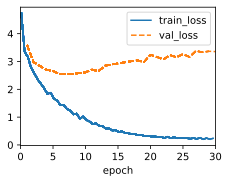

In [10]:
data = d2l.MTFraEng(batch_size=128)
embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0.2
encoder = Seq2SeqEncoder(
    len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(
    len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
                lr=0.005)
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

## [**预测**]

为了在每个步骤预测输出序列，
将前一个时间步的预测标记作为输入馈入解码器。
一种简单的策略是在每个步骤进行预测时，选择被解码器赋予最高概率的标记。
与训练一样，在初始时间步，
开始序列（"&lt;bos&gt;"）标记被馈入解码器。
这个预测过程
如 :numref:`fig_seq2seq_predict` 所示。
当预测到结束序列（"&lt;eos&gt;"）标记时，
输出序列的预测就完成了。

![使用RNN编码器-解码器逐个标记预测输出序列。](../img/seq2seq-predict.svg)
:label:`fig_seq2seq_predict`

在下一节中，我们将介绍
基于束搜索的更复杂的策略 (:numref:`sec_beam-search`)。

In [11]:
@d2l.add_to_class(d2l.EncoderDecoder)  #@save
def predict_step(self, batch, device, num_steps,
                 save_attention_weights=False):
    batch = [a.to(device) for a in batch]
    src, tgt, src_valid_len, _ = batch
    enc_all_outputs = self.encoder(src, src_valid_len)
    dec_state = self.decoder.init_state(enc_all_outputs, src_valid_len)
    outputs, attention_weights = [tgt[:, (0)].unsqueeze(1), ], []
    for _ in range(num_steps):
        Y, dec_state = self.decoder(outputs[-1], dec_state)
        outputs.append(Y.argmax(2))
        # Save attention weights (to be covered later)
        if save_attention_weights:
            attention_weights.append(self.decoder.attention_weights)
    return torch.cat(outputs[1:], 1), attention_weights

## 预测序列的评估

我们可以通过将预测序列与目标序列（即真实值）进行比较来评估预测序列。但是，衡量两个序列之间相似性的恰当标准究竟是什么呢？

双语评估替补（BLEU），尽管最初是为评估机器翻译结果而提出的 :cite:`Papineni.Roukos.Ward.ea.2002`，已被广泛用于测量不同应用中输出序列的质量。原则上，对于预测序列中的任何$n$-gram（:numref:`subsec_markov-models-and-n-grams`），BLEU 评估这个 $n$-gram 是否出现在目标序列中。

令 $p_n$ 表示 $n$-gram 的精确度，定义为预测序列和目标序列中匹配的 $n$-gram 数量与预测序列中 $n$-gram 总数的比例。例如，给定一个目标序列 $A$, $B$, $C$, $D$, $E$, $F$ 和一个预测序列 $A$, $B$, $B$, $C$, $D$，我们有 $p_1 = 4/5$,  $p_2 = 3/4$, $p_3 = 1/3$, 和 $p_4 = 0$。现在设 $\textrm{len}_{\textrm{label}}$ 和 $\textrm{len}_{\textrm{pred}}$ 分别为目标序列和预测序列中的标记数量。则 BLEU 定义为

$$ \exp\left(\min\left(0, 1 - \frac{\textrm{len}_{\textrm{label}}}{\textrm{len}_{\textrm{pred}}}\right)\right) \prod_{n=1}^k p_n^{1/2^n},$$
:eqlabel:`eq_bleu`

其中 $k$ 是用于匹配的最长 $n$-gram。

根据 :eqref:`eq_bleu` 中 BLEU 的定义，每当预测序列与目标序列相同时，BLEU 值为 1。此外，由于匹配更长的 $n$-gram 更困难，当较长的 $n$-gram 精确度高时，BLEU 给予更大的权重。具体来说，当 $p_n$ 固定时，随着 $n$ 的增长 $p_n^{1/2^n}$ 增加（原始论文使用 $p_n^{1/n}$）。此外，由于预测较短序列倾向于产生更高的 $p_n$ 值，:eqref:`eq_bleu` 中乘法项前的系数惩罚了较短的预测序列。例如，当 $k=2$ 时，给定目标序列 $A$, $B$, $C$, $D$, $E$, $F$ 和预测序列 $A$, $B$，虽然 $p_1 = p_2 = 1$，但惩罚因子 $\exp(1-6/2) \approx 0.14$ 降低了 BLEU。

我们[**实现 BLEU 度量**]如下。

In [12]:
def bleu(pred_seq, label_seq, k):  #@save
    """Compute the BLEU."""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, min(k, len_pred) + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

最终，我们使用训练好的RNN编码器-解码器来[**将一些英语句子翻译成法语**]并计算结果的BLEU值。

In [13]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
    data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{bleu(" ".join(translation), fr, k=2):.3f}')

go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['elle', 'court', '.'], bleu,0.000
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000


## 摘要

遵循编码器-解码器架构的设计，我们可以使用两个RNN来设计一个序列到序列学习的模型。
在编码器-解码器训练中，教师强制方法将原始输出序列（而非预测值）输入解码器。
在实现编码器和解码器时，我们可以使用多层RNN。
我们可以使用掩码来过滤掉无关的计算，例如在计算损失时。
为了评估输出序列，
BLEU是一种流行的方法，它匹配预测序列和目标序列之间的$n$-gram。


## 练习

1. 你能调整超参数以改善翻译结果吗？
1. 不使用掩码进行损失计算的情况下重新运行实验。你观察到了什么结果？为什么？
1. 如果编码器和解码器在层数或隐藏单元数上不同，我们如何初始化解码器的隐藏状态？
1. 在训练中，用前一时间步的预测代替教师强制输入解码器。这如何影响性能？
1. 用LSTM替换GRU重新运行实验。
1. 是否有其他方式设计解码器的输出层？

[讨论](https://discuss.d2l.ai/t/1062)